### Necessary imports

In [1]:
# Required imports
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import re
import string
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\hp\AppData\Local\Temp\ipykernel_12156\2518021868.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


### Loading the word embeddings

In [3]:
def load_glove_model(glove_file):
    """
    :param glove_file: embeddings_path: path of glove file.
    :return: glove model
    """

    f = open(glove_file + ".txt", 'r', encoding='utf-8')
    model = {}
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
    return model
# model.get(word, output_array)
# output array of shape (300,) or whichever embedding length you loaded

In [4]:
vec_source = "Word_Vec\glove.42B.300d\glove.42B.300d"
word_2_vec_dict = load_glove_model(vec_source)

### Preprocessing the input data

In [9]:
# train_df = pd.read_csv("amazon_review_full_csv/train.csv")
train_df = pd.read_csv("amazon_review_full_csv/train.csv", names=['score', 'brief', 'desc'])

test_df = pd.read_csv("amazon_review_full_csv/test.csv")

In [10]:
# test_df = test_df.drop(columns= ['brief'])
train_df = train_df[400000:450000]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 400000 to 449999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   50000 non-null  int64 
 1   brief   49998 non-null  object
 2   desc    50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# initializing preprocessing components

trans = str.maketrans("", "", string.punctuation)
# stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
avg_embd = np.mean(list(word_2_vec_dict.values()), axis=0)

In [16]:
# Defining cleaning and embedding convertion functions
stop_words = set()

def word_2_arr(word):
    embd = word_2_vec_dict.get(word)          # gets the embd of words
    if type(embd) != np.ndarray:              # checks for unkown words
        return avg_embd
    return embd

def analysis_clean(sentence):
    sentence = str(sentence.numpy())[2:-1].translate(trans)                                # Remove punctuation
    li = nltk.word_tokenize(sentence)                                                      # toeknize
    li = [lem.lemmatize(i.lower()) for i in li if i.lower() not in stop_words] # remove stop_words, lowercase, lemmatize
    return li

def clean_embd(sentence, score):                                 # takes sentence and ouputs embedding matrix of the sentence
    sentence = str(sentence.numpy())[2:-1].translate(trans)                                # Remove punctuation
    li = nltk.word_tokenize(sentence)                                                      # toeknize
    li = [word_2_arr(lem.lemmatize(i.lower())) for i in li if i.lower() not in stop_words] # remove stop_words, lowercase, lemmatize, to word embedding
    return li, score

def clean_embd_map_fn(sentence, score):                          # tensorflow map version of the the above function
    # sentence, score = line
    embd_sentence, score = tf.py_function(
        clean_embd, inp=[sentence, score], Tout=(tf.float64, tf.float32),
    )
    score = tf.cast(score, dtype = tf.int32)
    embd_sentence.set_shape([None, 300])
    score.set_shape([5,])
    return embd_sentence, score

In [13]:
# Creating the train and validation datasets

labels = tf.one_hot(train_df.score-1, 5)
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df.desc), np.array(labels), test_size=0.1, random_state=13)
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_len = ds_train.cardinality()
val_len = ds_val.cardinality()

In [14]:
# Applying preprocssing on the datasets

AUTO = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(clean_embd_map_fn, num_parallel_calls=AUTO)
# ds_train = ds_train.shuffle()
ds_train = ds_train.padded_batch(128, padded_shapes=([None, 300], [5,]))
ds_train = ds_train.prefetch(AUTO)

ds_val = ds_val.map(clean_embd_map_fn, num_parallel_calls=AUTO)
ds_val = ds_val.padded_batch(128, padded_shapes=([None, 300], [5,]))
ds_val = ds_val.prefetch(AUTO)

### Creating the model

In [11]:

inp = tf.keras.Input(shape = (None, 300))
x = layers.Masking(mask_value=0)(inp)
x = layers.LSTM(256, return_sequences = True)(x)
# x = layers.Dropout(0.3)(x)
x = layers.LSTM(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(5)(x)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"],
)



In [7]:
model = tf.keras.models.load_model('senti_saved_non_bi')

In [5]:
# Run this cell twice because of a complication with an wordnet in nltk (will get an error the first time)
logs = "logs_bi"  
tb_call = tf.keras.callbacks.TensorBoard(
    log_dir = logs,
    histogram_freq = 1,
    profile_batch = '300, 320'
)

model.fit(ds_train, epochs=1, verbose=1, validation_data=ds_val)

In [ ]:
# model.save('senti_saved_non_bi')

### Model Analysis

In [ ]:
pred_df = test_df[10:19]

labels = tf.one_hot(pred_df.score-1, 5)
ds_pred = tf.data.Dataset.from_tensor_slices((pred_df.desc, labels))
pred_len = ds_pred.cardinality()
ds_pred = ds_pred.map(clean_embd_map_fn, num_parallel_calls=AUTO)
ds_pred = ds_pred.padded_batch(64, padded_shapes=([None, 300], [5,]))
# for line, label in ds_pred:
#     print(model.predict(line))


###############################################
array_dim = train_len

prediction_matrix = np.zeros((array_dim, 5))
def hardmax(batch_output):
    for array in batch_output:
        maxi = max(array)
        for i in range(5):
            if array[i] == maxi:
                array[i] = 1
            else:
                array[i] = 0
        prediction_matrix[hardmax.it] = array
        hardmax.it += 1
hardmax.it =0
truth = np.zeros((array_dim, 5))

it = 0
for batch in ds_train:
    x, y = batch
    hardmax(model.predict(x))
    for label in y:
        truth[it] = label
        it+= 1

conf = confusion_matrix(truth.argmax(1), prediction_matrix.argmax(1))
sns.heatmap(conf)

### Predictions to custom inputs

In [30]:
def senti_pred(pred_lines):
    
    # getting the data in the correct input format
    pred_df = pd.DataFrame({
    'desc':pred_lines,
    'score':list(np.ones(len(pred_lines)))
    })

    labels = tf.one_hot(pred_df.score-1, 5)
    ds_pred = tf.data.Dataset.from_tensor_slices((pred_df.desc, labels))
    pred_len = ds_pred.cardinality()
    ds_pred = ds_pred.map(clean_embd_map_fn, num_parallel_calls=AUTO)
    ds_pred = ds_pred.padded_batch(64, padded_shapes=([None, 300], [5,]))

    # getting the predictions
    it = 0
    pred_3 = np.zeros((len(pred_lines),), dtype="object")
    
    for batch in ds_pred:
        x, y = batch
        for one_hot_pred in model.predict(x, verbose=0):

            extr_dic = {0: "negative", 2: "neutral", 4:"positive"}
            
            max_score = np.argmax(one_hot_pred)
            print(max_score)
            if max_score == 1:
                pred = extr_dic[np.argmax((one_hot_pred[0], one_hot_pred[2]))*2]
            elif max_score == 3:
                pred = extr_dic[np.argmax((one_hot_pred[2], one_hot_pred[4]))*2+2]
            else:
                pred = extr_dic[max_score]

            pred_3[it] = pred
            it+= 1

    return pred_3


lines = ["this is the worst day ever, over 10 people are dead",
         "I'm having so much fun in the disneyland!",
         "not too shabby, not too good either",
         "The world is not cruel and dire",
         "The world is cruel and dire",
         "This is ok, I guess"]

senti_pred(lines)

0
4
2
4
0
2


array(['negative', 'positive', 'neutral', 'positive', 'negative',
       'neutral'], dtype=object)

<Axes: >

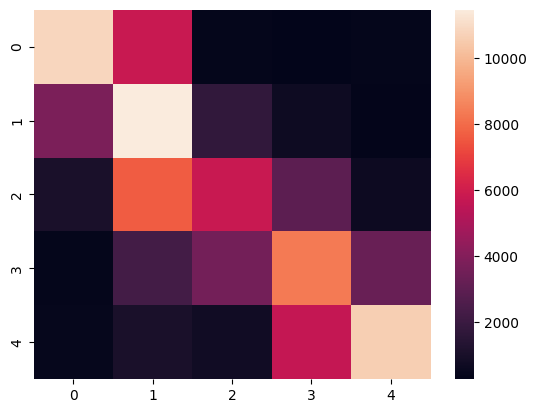

<Axes: >

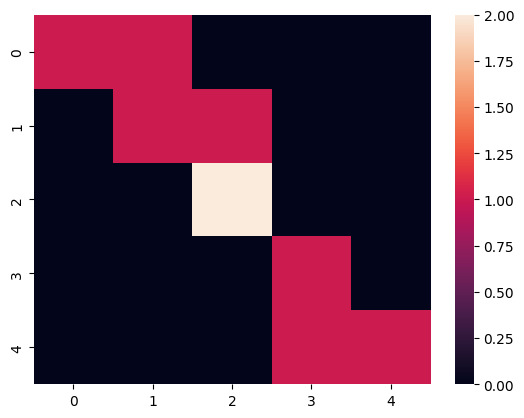

In [84]:
confusion_matrix([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]],
        
        [[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])
# 2, 2, 1, 0, 3, 4, 2, 1, 4 pred
# 2, 2, 1, 0, 4, 4, 2, 0, 3 truth

